In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
#Other necessary imports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import keras
from keras import models
from keras import layers
from keras.models import load_model
from sklearn.utils import compute_class_weight

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

Source for plot confusion matrix: <br> https://stackoverflow.com/questions/69875073/confusion-matrix-valueerror-classification-metrics-cant-handle-a-mix-of-binary

In [3]:
#Evaluate each model
def evaluate_model(model, x_train, y_train, x_val, y_val):
    '''
    Evaluate model by displaying confusion matrix of validation data, 
    and also by displaying a DataFrame with Loss, Accuracy, Recall, and AUC-ROC for both train and val datasets
    
    Input: 
    -model to be evaluated
    -x_train: predictors from training data
    -y_train: target from training data
    -x_val: predictors from validation data
    -y_val: target from validation data
    
    Output:
    -Confusion matrix of y_val and model predictions
    -DataFrame with Loss, Accuracy, Recall, and AUC-ROC for both train and val datasets
    '''

    #Plot Confusion Matrix
    y_preds = model.predict(x_val)
    y_preds = y_preds.flatten()
    y_preds = np.where(y_preds > 0.5, 1, 0)
    cm = confusion_matrix(y_val, y_preds, normalize = None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot()
    plt.show()
    
    #Create a DataFrame with the results 
    model_train = model.evaluate(x_train, y_train, verbose=0)
    model_val = model.evaluate(x_val, y_val, verbose=0)
    model_results = {"Training":[],"Validation":[]};
    for i in range(4):
        model_results['Training'].append(round(model_train[i],3))
        model_results['Validation'].append(round(model_val[i],3))
    model_results_df = pd.DataFrame.from_dict(data = model_results,
                                                   orient = 'index', 
                                                   columns = ['Loss', 'Accuracy', 'Recall', 'AUC-ROC'])
    display(model_results_df)

# Load Preprocessed Data

In [4]:
#Load data
train_images = np.load('../input/eda-and-data-preprocessing/train_images.npy')
train_labels = np.load('../input/eda-and-data-preprocessing/train_labels.npy')

train_images_third = np.load('../input/eda-and-data-preprocessing/train_images_third.npy')
train_labels_third = np.load('../input/eda-and-data-preprocessing/train_labels_third.npy')

val_images = np.load('../input/eda-and-data-preprocessing/val_images.npy')
val_labels = np.load('../input/eda-and-data-preprocessing/val_labels.npy')

test_images = np.load('../input/eda-and-data-preprocessing/test_images.npy')
test_labels = np.load('../input/eda-and-data-preprocessing/test_labels.npy')

In [5]:
#Explore the dataset again
print ("Number of training samples: " + str(train_images.shape[0]))
print ("A third of training samples: " + str(train_images_third.shape[0]))
print ("Number of validation samples: " + str(val_images.shape[0]))
print ("Number of testing samples: " + str(test_images.shape[0]))
print ("===")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("A third of train_images shape: " + str(train_images_third.shape))
print ("A third of train_labels shape: " + str(train_labels_third.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 25803
A third of training samples: 8601
Number of validation samples: 8602
Number of testing samples: 3823
===
train_images shape: (25803, 128, 128, 3)
train_labels shape: (25803,)
A third of train_images shape: (8601, 128, 128, 3)
A third of train_labels shape: (8601,)
val_images shape: (8602, 128, 128, 3)
val_labels shape: (8602,)
test_images shape: (3823, 128, 128, 3)
test_labels shape: (3823,)


# Load Models

In [8]:
#Load second cnn model with dropouts
second_cnn_model = load_model('../input/vgg16-model-with-balanced-class-weight/best_vgg16_model_balanced.h5')
second_cnn_model.summary()

2021-12-03 03:31:35.086166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 03:31:35.245071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 03:31:35.245763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 03:31:35.246912: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


# Evaluate

2021-12-03 03:31:45.033440: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691222016 exceeds 10% of free system memory.
2021-12-03 03:31:46.804045: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691222016 exceeds 10% of free system memory.
2021-12-03 03:31:48.070739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-03 03:31:49.036810: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


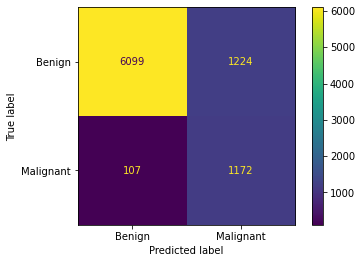

2021-12-03 03:32:03.937047: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691025408 exceeds 10% of free system memory.
2021-12-03 03:32:05.842276: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691025408 exceeds 10% of free system memory.
2021-12-03 03:32:16.410082: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691222016 exceeds 10% of free system memory.


,Loss,Accuracy,Recall,AUC-ROC
Training,0.322,0.866,0.971,0.98
Validation,0.369,0.845,0.916,0.95


In [9]:
#Evaluate second cnn model dropouts
evaluate_model(second_cnn_model, train_images_third, train_labels_third, val_images, val_labels)